In [1]:
import cv2
import os
from tqdm import tqdm 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
dataset = 'D:/MSc/SEMESTER 3/DL/LAB6/DATA/data'

# Loading the training data

In [14]:
data_dir = 'D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train'
train_df = loading_the_data(data_dir)

train_df

,filepaths,labels
0,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\beni...,benign
1,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\beni...,benign
2,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\beni...,benign
3,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\beni...,benign
4,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\beni...,benign
...,...,...
2632,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\mali...,malignant
2633,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\mali...,malignant
2634,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\mali...,malignant
2635,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train\mali...,malignant


# Loading the testing data

In [15]:

data_dir = r'D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test'
ts_df = loading_the_data(data_dir)

ts_df

,filepaths,labels
0,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\benig...,benign
1,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\benig...,benign
2,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\benig...,benign
3,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\benig...,benign
4,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\benig...,benign
...,...,...
655,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\malig...,malignant
656,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\malig...,malignant
657,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\malig...,malignant
658,D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test\malig...,malignant


# Data Preprocessing

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen():
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        rotation_range=15,  # Random rotations
        horizontal_flip=True,  # Random horizontal flips
        zoom_range=0.1  # Random zoom
    )

    # For testing, only rescaling is needed
    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def load_data_with_generator(train_dir, test_dir, img_size=64, batch_size=32):
    train_datagen, test_datagen = create_datagen()

    # Create a training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    # Create a testing data generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    return train_generator, test_generator

# Define your directories
train_dir = 'D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/train'
test_dir = 'D:/MSc/SEMESTER 3/DL/LAB6/DATA/data/test'

train_generator, test_generator = load_data_with_generator(train_dir, test_dir)



Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


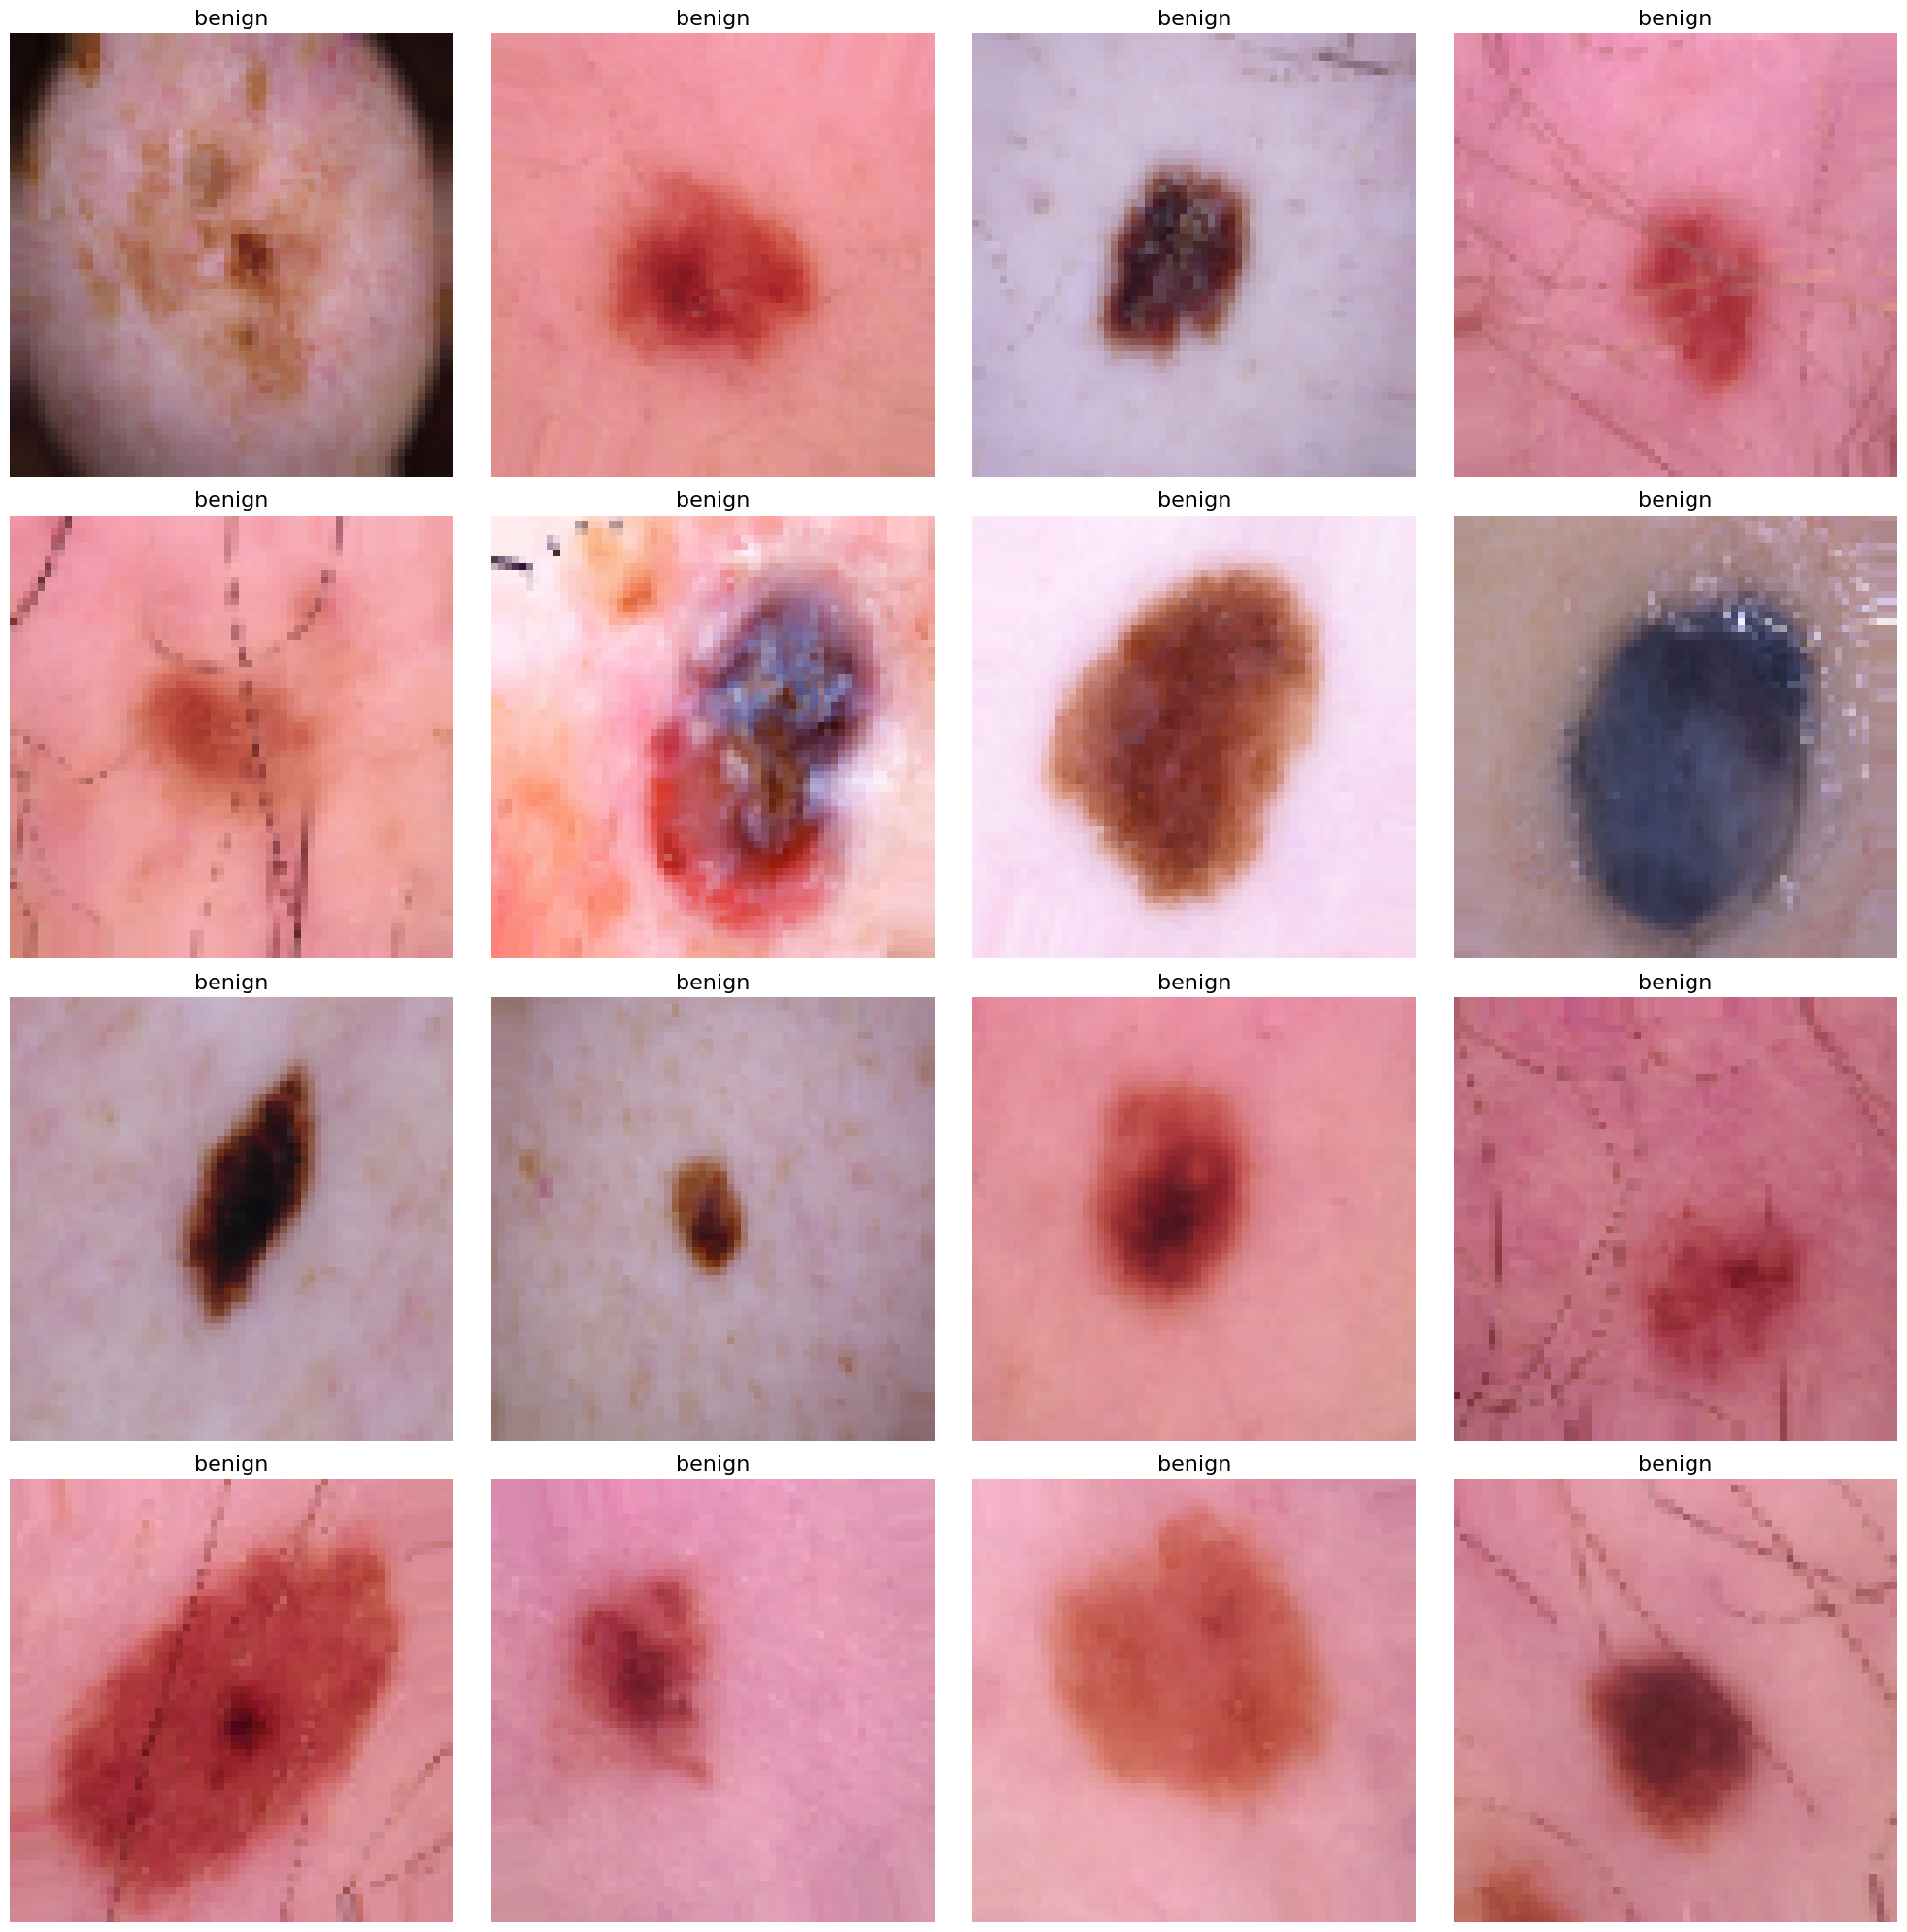

In [17]:
def display_sample_images(generator):
    """
    Display a batch of images from a data generator.
    """
    images, labels = next(generator)  
    classes = list(generator.class_indices.keys())  
    
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i]) 
        class_name = classes[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
        if i == 15:  
            break
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator)


# Build Custom CNN

In [18]:
def build_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])
    return model

custom_cnn_model = build_custom_cnn((64, 64, 3), 1)

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()

c:\Users\noelm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,176,385 (4.49 MB)

 Trainable params: 1,176,385 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_custom_cnn = custom_cnn_model.fit(
    train_generator, 
    validation_data=test_generator, 
    epochs=10,  
    batch_size=32)  

Epoch 1/10


c:\Users\noelm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 635ms/step - accuracy: 0.6377 - loss: 0.6205 - val_accuracy: 0.7333 - val_loss: 0.6261
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.7569 - loss: 0.5063 - val_accuracy: 0.7924 - val_loss: 0.4369
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.7729 - loss: 0.4737 - val_accuracy: 0.8273 - val_loss: 0.3841
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.7928 - loss: 0.4246 - val_accuracy: 0.7576 - val_loss: 0.4311
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.7889 - loss: 0.4415 - val_accuracy: 0.8091 - val_loss: 0.3802
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.7996 - loss: 0.4128 - val_accuracy: 0.8091 - val_loss: 0.3883
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.8032 - loss: 0.4032 - val_accuracy: 0.8030 - val_loss: 0.3898
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.8278 - loss: 0.3648 - val_accuracy: 0.833

In [20]:
test_loss, test_acc = custom_cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8008 - loss: 0.3805
Test accuracy: 0.8121212124824524, Test loss: 0.36571648716926575


In [21]:
test_generator.reset() 
predictions_custom_cnn = custom_cnn_model.predict(test_generator)
predicted_classes_custom_cnn = (predictions_custom_cnn > 0.5).astype(int)
true_classes = test_generator.classes

print("Custom CNN Model Evaluation")
print(classification_report(true_classes, predicted_classes_custom_cnn))

fpr, tpr, thresholds = roc_curve(true_classes, predictions_custom_cnn)
roc_auc = auc(fpr, tpr)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
Custom CNN Model Evaluation
              precision    recall  f1-score   support

           0       0.57      0.42      0.49       360
           1       0.47      0.62      0.53       300

    accuracy                           0.51       660
   macro avg       0.52      0.52      0.51       660
weighted avg       0.53      0.51      0.51       660



# VGG16 Model

In [22]:
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg16_model = build_vgg16_model((64, 64, 3), 1)

vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10, 
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6996 - loss: 0.6106 - val_accuracy: 0.8015 - val_loss: 0.4128
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8122 - loss: 0.4055 - val_accuracy: 0.8212 - val_loss: 0.4048
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8194 - loss: 0.3962 - val_accuracy: 0.8106 - val_loss: 0.3752
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 1000ms/step - accuracy: 0.8237 - loss: 0.3725 - val_accuracy: 0.8318 - val_loss: 0.3590
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8354 - loss: 0.3454 - val_accuracy: 0.8333 - val_loss: 0.3618
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8209 - loss: 0.3621 - val_accuracy: 0.8348 - val_loss: 0.3490
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8508 - loss: 0.3273 - val_accuracy: 0.8197 - val_loss: 0.3615
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8198 - loss: 0.3849 - val_accuracy: 0.8212 - v

In [24]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8386 - loss: 0.3407
Test accuracy: 0.8378787636756897, Test loss: 0.3345470726490021


In [25]:
test_generator.reset()  
predictions_vgg16 = vgg16_model.predict(test_generator)
predicted_classes_vgg16 = (predictions_vgg16 > 0.5).astype(int)

print("VGG16 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg16))

fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(true_classes, predictions_vgg16)
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
VGG16 Model Evaluation
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       360
           1       0.43      0.49      0.46       300

    accuracy                           0.47       660
   macro avg       0.47      0.47      0.47       660
weighted avg       0.48      0.47      0.47       660



# Build the VGG19 Model

In [26]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models, layers

def build_vgg19_model(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg19_model = build_vgg19_model((64, 64, 3), 1)

vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [27]:
history_vgg19 = vgg19_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6763 - loss: 0.6201 - val_accuracy: 0.8000 - val_loss: 0.4270
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7956 - loss: 0.4410 - val_accuracy: 0.8197 - val_loss: 0.4011
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7939 - loss: 0.4251 - val_accuracy: 0.8091 - val_loss: 0.3853
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8067 - loss: 0.4183 - val_accuracy: 0.8515 - val_loss: 0.3623
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8106 - loss: 0.3963 - val_accuracy: 0.8364 - val_loss: 0.3582
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8172 - loss: 0.3919 - val_accuracy: 0.8045 - val_loss: 0.4037
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8311 - loss: 0.3714 - val_accuracy: 0.8333 - val_loss: 0.3482
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8112 - loss: 0.3878 - val_accuracy: 0.8045 - v

In [28]:
test_loss, test_acc = vgg19_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8230 - loss: 0.3381
Test accuracy: 0.821212112903595, Test loss: 0.3560306131839752


In [29]:
test_generator.reset()  
predictions_vgg19 = vgg19_model.predict(test_generator)
predicted_classes_vgg19 = (predictions_vgg19 > 0.5).astype(int)


21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


In [30]:
print("VGG19 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg19))

fpr_vgg19, tpr_vgg19, thresholds_vgg19 = roc_curve(true_classes, predictions_vgg19)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

VGG19 Model Evaluation
              precision    recall  f1-score   support

           0       0.54      0.41      0.46       360
           1       0.45      0.58      0.51       300

    accuracy                           0.48       660
   macro avg       0.49      0.49      0.48       660
weighted avg       0.50      0.48      0.48       660



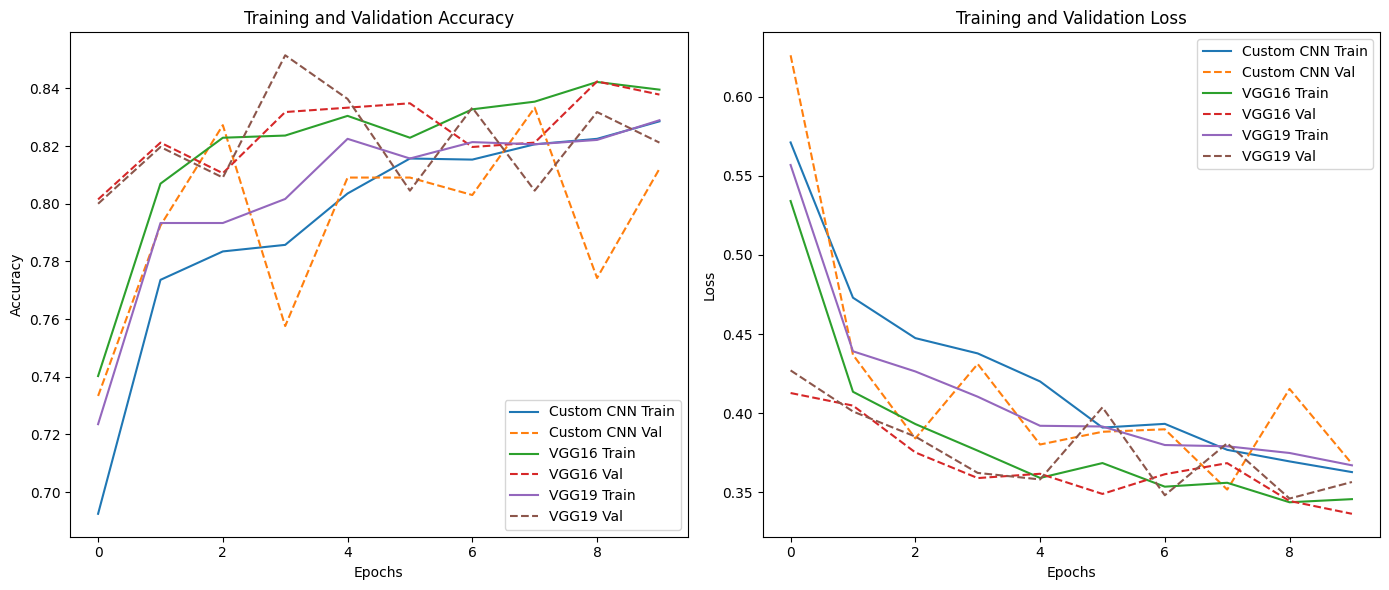

In [31]:
def plot_model_history(model_histories, labels, metric='accuracy'):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history[metric], label=f'{label} Train')
        plt.plot(history.history[f'val_{metric}'], '--', label=f'{label} Val')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train')
        plt.plot(history.history['val_loss'], '--', label=f'{label} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(
    [history_custom_cnn, history_vgg16, history_vgg19],
    ['Custom CNN', 'VGG16', 'VGG19']
)

Custom CNN Model Confusion Matrix


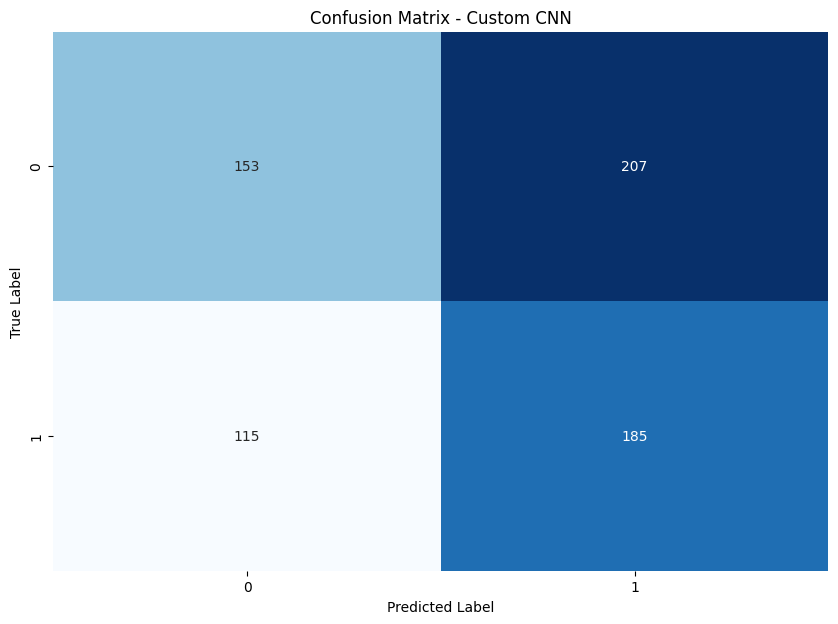

VGG16 Model Confusion Matrix


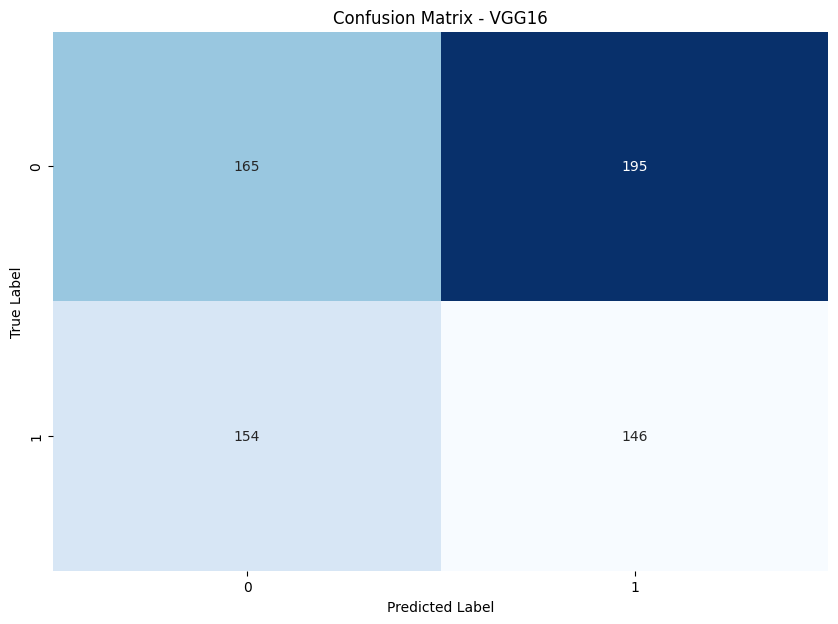

VGG19 Model Confusion Matrix


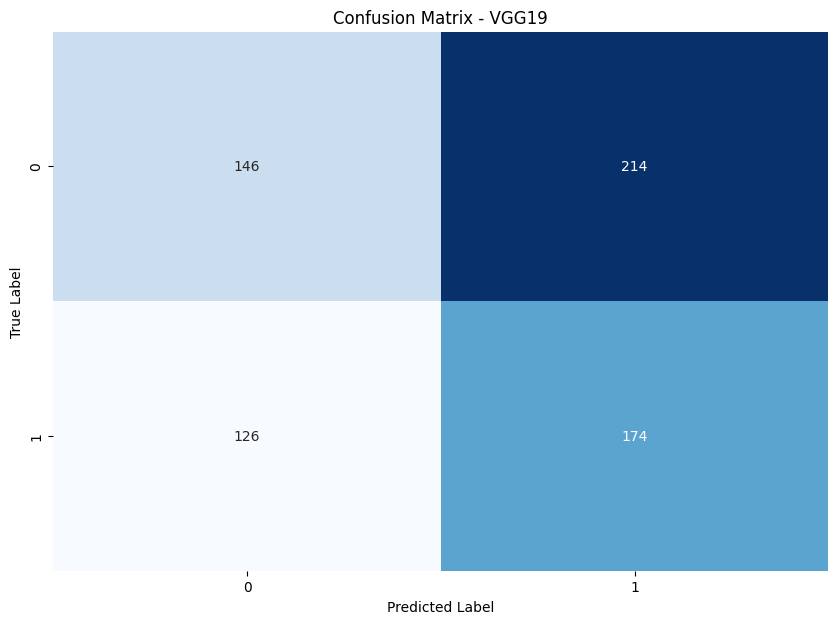

In [32]:
def plot_confusion_matrix(true_classes, predicted_classes, title='Confusion Matrix'):
    matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("Custom CNN Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_custom_cnn, 'Confusion Matrix - Custom CNN')

print("VGG16 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg16, 'Confusion Matrix - VGG16')

print("VGG19 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg19, 'Confusion Matrix - VGG19')


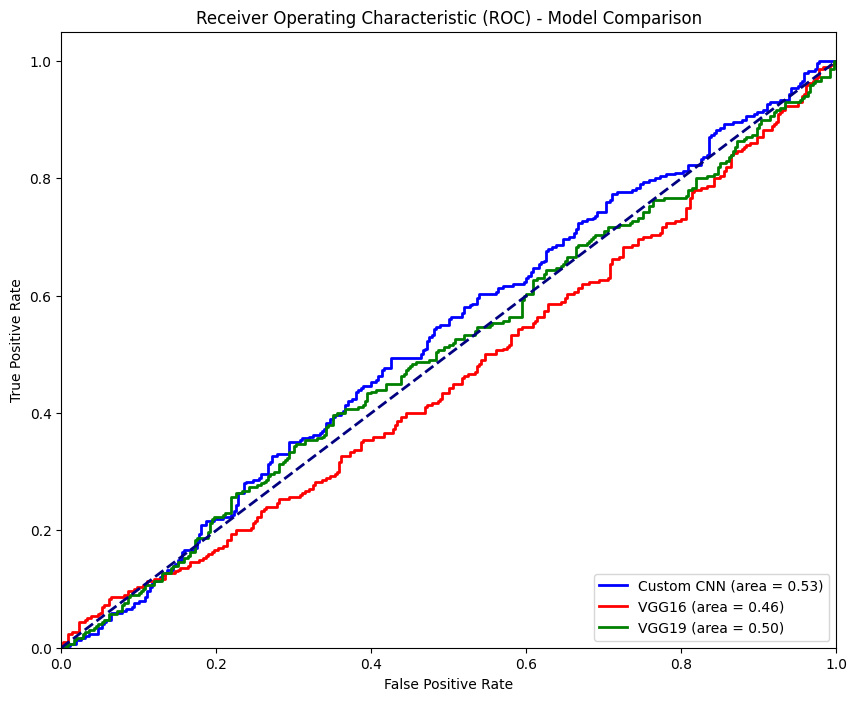

In [33]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Custom CNN (area = {roc_auc:.2f})')

plt.plot(fpr_vgg16, tpr_vgg16, color='red', lw=2, label=f'VGG16 (area = {roc_auc_vgg16:.2f})')

plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label=f'VGG19 (area = {roc_auc_vgg19:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model Comparison')
plt.legend(loc="lower right")
plt.show()